# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import project_tests as t

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
print("Number of Unique Article Ids: ", df['article_id'].nunique())
print("Number of Unique Users: ", df['email'].nunique())
print(df.groupby(['email'])['article_id'].count().describe())

Number of Unique Article Ids:  714
Number of Unique Users:  5148
count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


In [5]:
interacts_user = df.groupby(['email']).count()['article_id']
interacts_user.head()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

In [6]:
# Fill in the median and maximum number of user_article interactios below
median_val = 3.0# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364.0# The maximum number of user-article interactions by any 1 user is ______.

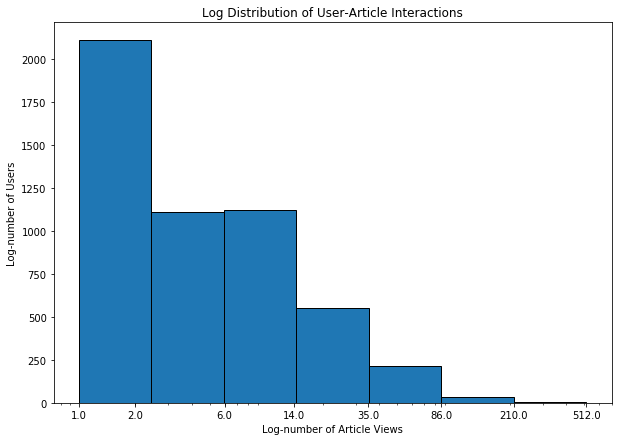

In [7]:
bins = np.arange(1,9)**3
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

plt.figure(figsize=(10,7))
plt.hist(interacts_user, bins=logbins, ec='black');

plt.yscale('linear')
plt.xscale('log')
plt.xticks(np.round(logbins), np.round(logbins).astype(str))

plt.title('Log Distribution of User-Article Interactions')
plt.xlabel('Log-number of Article Views')
plt.ylabel('Log-number of Users')
plt.show()

`2.` Explore and remove duplicate articles from the **df_content** dataframe. 

In [8]:
# Find and explore duplicate articles
for col in ['doc_body', 'doc_description', 'doc_full_name', 'article_id']:
    print(col, df_content.duplicated(subset=[col]).sum())
    
dupl_ids = df_content.duplicated(subset=['article_id'])
df_content[dupl_ids]


doc_body 19
doc_description 33
doc_full_name 5
article_id 5


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [9]:
# Remove any rows that have the same article_id - only keep the first
print('{} data points before dropping duplicate article ids'.format(df_content.shape[0]))
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)
print('{} data points after removing duplicate article ids'.format(df_content.shape[0]))

1056 data points before dropping duplicate article ids
1051 data points after removing duplicate article ids


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles = df.article_id.nunique()# The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique()# The number of unique articles on the IBM platform
unique_users = df.email.nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
df.groupby('article_id').count()['email'].sort_values(ascending=False).head()


article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [12]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    ranked_idxs = df.groupby('article_id').count()['user_id'].sort_values(ascending=False).index
    d = df.set_index('article_id')
    top_articles = list(d.loc[ranked_idxs]['title'].unique())[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    ranked_idxs = df.groupby('article_id').count()['user_id'].sort_values(ascending=False).index
    d = df.set_index('article_id')
    top_articles = list(d.loc[ranked_idxs].index.unique())[:n]
    top_articles = [str(i) for i in top_articles]
    
    return top_articles # Return the top article ids

In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [18]:
test = df.head()
test['interaction'] = 1
test.groupby(['user_id', 'article_id'])['interaction'].max().unstack().fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


article_id,1276.0,1314.0,1338.0,1429.0,1430.0
user_id,,,,,
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0


In [19]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df['interaction'] = 1
    user_item = df.groupby(['user_id', 'article_id'])['interaction'].max().unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
def find_similar_users(user_id, user_item=user_item, sim_measure='dot'):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    from scipy.spatial.distance import squareform, pdist
    
    if sim_measure == 'dot':
        dists = user_item.dot(user_item.T)
    
    elif sim_measure == 'eucliean':
        dists = pd.DataFrame(squareform(pdist(user_item, 'euclidean')))   
    
    else:
        print("optional arg sim_measure must either be 'dot' or 'euclidean'")

    ordered = dists[user_id].sort_values(ascending=False)
    most_similar_users = [i for i in ordered.index if i != user_id]
    most_similar_vals = ordered.loc[most_similar_users]
       
    return most_similar_users, most_similar_vals
        

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[0][:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[0][:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[0][:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(user_item.loc[user_id][user_item.loc[user_id] > 0].index.astype(str))
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    read_article_ids, read_article_names = get_user_articles(user_id)
    neighbours = find_similar_users(user_id)[0]
    
    recs = np.array([])
    
    for user in neighbours:
        
        neigh_ids, neigh_names = get_user_articles(user)        
        rec_list = np.setdiff1d(neigh_ids, recs, assume_unique=True)        
        recs = np.unique(np.concatenate([rec_list, recs], axis=0))
                
        if len(recs) >= m:
            break
    
    if len(recs) > m:    
        recs = recs[:m]    
    elif len(recs) < m:
        recs = recs
        
    return recs # return your recommendations for this user_id    

In [24]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['access db2 warehouse on cloud and db2 with python',
 'putting a human face on machine learning',
 'predict loan applicant behavior with tensorflow neural networking',
 'classify tumors with machine learning',
 'tensorflow quick tips',
 'categorize urban density',
 'apache spark lab, part 1: basic concepts',
 'finding optimal locations of new store using decision optimization',
 'gosales transactions for naive bayes model',
 'country statistics: life expectancy at birth']

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neigh_ids, neigh_vals = find_similar_users(user_id)
    interactions = df['user_id'].value_counts().loc[neigh_ids]
    neighbors_df = pd.DataFrame(data={'neighbor_id':neigh_ids,
                              'sim_val':neigh_vals,
                              'interactions':interactions}).sort_values(by=['sim_val', 'interactions'], ascending=False)
    neighbors_df.reset_index(drop=True, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    read_article_ids, read_article_names = get_user_articles(user_id)
    neighbours = find_similar_users(user_id)[0]
    
    recs = np.array([])
    
    for user in neighbours:
        
        neigh_ids, neigh_names = get_user_articles(user)        
        rec_list = np.setdiff1d(neigh_ids, recs, assume_unique=True)        
        recs = np.unique(np.concatenate([rec_list, recs], axis=0))
                
        if len(recs) >= m:
            break
    
    if len(recs) > m:    
        recs = recs[:m]    
    elif len(recs) < m:
        recs = recs
    
    rec_names = get_article_names(recs)
        
    return recs, rec_names

In [27]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1006.0' '1035.0' '109.0' '111.0' '112.0' '1154.0' '1160.0' '1162.0'
 '1165.0' '1172.0']

The top 10 recommendations for user 20 are the following article names:
['essentials of machine learning algorithms (with python and r codes)', 'building custom machine learning algorithms with apache systemml', 'tensorflow quick tips', 'analyze energy consumption in buildings', 'apache spark lab, part 3: machine learning', 'analyze precipitation data', 'machine learning for the enterprise.', 'airbnb data for analytics: vienna listings', 'tidy up your jupyter notebooks with scripts', 'analyze accident reports on amazon emr spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [28]:
print(get_top_sorted_users(1).loc[0, 'neighbor_id'])
print(get_top_sorted_users(131).loc[9, 'neighbor_id'])

3933
242


In [29]:
### Tests with a dictionary of results

user1_most_sim = 3933
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [30]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Response:**

New users entering the system can be recommended the most popular articles - since there is no prior data to infer from for more specific recommendations. The **get_top_article_ids** function is what should be used here. 

Content-based recommendation, or a hybrid approach of content and collaborative filtering, can be used to work aroud the cold start problem. I would propose the use of text/topic mining from articles that the user does initially read, and compare these vectors with others. From a more business-oriented perspective, users logging in with social media credentials could potentially already hold preference data linked to their accounts. This too can be leveraged.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [31]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)


In [32]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

### Optional Section: Content Based Recommendations Using Cosine Similarity of Article Titles


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

class CosineRecSys():
    
    def __init__(self, df_content, df, user_item_matrix):
        self.articles = df_content[['article_id', 'doc_full_name']]
        self.df = df.drop_duplicates(subset='article_id', keep='first')

        self.user_item = user_item_matrix
        self.vect = TfidfVectorizer(stop_words='english', smooth_idf=True)
        
        self.tfidf_matrix = self.vect.fit_transform(self.df['title'])
        self.cosine_matrix= pd.DataFrame(linear_kernel(self.tfidf_matrix, self.tfidf_matrix),
                                        columns=self.df.article_id,
                                        index=self.df.article_id)
        
    def create_user_item_matrix(self):
        
        self.df['interaction'] = 1
        user_item = self.df.groupby(['user_id', 'article_id'])['interaction'].max().unstack().fillna(0)
        return user_item
    
    def get_user_article_ids(self, user_id):
    
        article_ids = list(self.user_item.loc[user_id][self.user_item.loc[user_id] > 0].index)

        return article_ids

    def get_related_article_ids(self, article_id, n_recs=5):

        scores = self.cosine_matrix[article_id]
        scores = scores[scores>0].sort_values(ascending=False).drop(article_id, axis=0) # sort by highest cosine, no 0 scores
        
        related_ids = scores.index
        return related_ids[:n_recs], scores.loc[related_ids[:n_recs]]
    
    def get_article_names(self, article_id_list):        
        return list(self.articles[self.articles['article_id'].isin(article_id_list)]['doc_full_name'])
    


In [34]:
def execute_recsys(user_id, max_recs=15):

    recsys = CosineRecSys(df_content, df, user_item)

    user_article_ids = recsys.get_user_article_ids(user_id)

    user_recs = np.array([])

    for article in user_article_ids:
        related_ids, _ = recsys.get_related_article_ids(article)

        new_recs = np.setdiff1d(related_ids, user_article_ids, assume_unique=True)
        user_recs = np.unique(np.concatenate([user_recs, new_recs]), axis=0)
        
        if len(user_recs) >= max_recs:
            
            break

    titles = recsys.get_article_names(user_recs)
    
    return titles, user_article_ids
    

In [35]:
recommended, read = execute_recsys(7)
print("Recommended by CosineRecSys: \n")
print(recommended)

print("\nRead by the User: \n")
print(np.unique(df[df.article_id.isin(read)]['title']))

Recommended by CosineRecSys: 

['Building Custom Machine Learning Algorithms With Apache SystemML', 'Deep Learning with Data Science Experience', 'Building Your First Machine Learning System ', 'Generalization in Deep Learning', 'A Classification Problem', 'Building a business that combines human experts and data science', 'Use the Machine Learning Library', 'How to Get a Job In Deep Learning']

Read by the User: 

['house building with worker skills'
 'use deep learning for image classification']


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

In this section I decided to provide an alternative to collaborative filtering, by calculating the cosine similarities between article titles. If at least one article is read by user, this system will be able to provide suggestions for other articles using this simple topic mining.

TF-IDF is used to vectorize all article titles before calculating the cosine similarity between all titles using a linear kernel from scikit-learn. 

I wrote a class so that attributes such as the cosine matrix & elements from the datasets could be easily integrated into all functions. The class can be instantiated and used to then generate recommended articles for any given user_id like in the function above.

The benefit of this system is that if a user reads even a single article, this can generate as many topically-related articles as possible with the controlling a simple parameter (max_recs). In the execution above User 7 has only read two articles, but this system is able to generate 8 related articles to pique User 7's interests further. 

Although it is not done here, this system can be adjusted so that the delivery of suggestions is more 'friendly' to the user. Rather than providing a single of list of all related articles, we could tweak this system such that it delivers multiple lists of articles are closely related to their own respective topics. 

Example:
User 5 reads an article on Apache Spark, but also reads an article on Image Classification. The related articles for Apache Spark could be grouped together and delivered in a way like: ***"Because you read Apache Spark article ..."***
    
The downside to this system however, is that it relies on previous User data - so this does not fully work around the **cold start** problem of collaborative filtering. I would take this solution and introduce Latent Semantic Analysis using Matrix Factorization in order to improve recommendations.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [37]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [38]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [39]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [40]:
print(u.shape)
print(s.shape)
print(vt.shape)

(5149, 5149)
(714,)
(714, 714)


In the lesson, the user_item_matrix had NaN values to indicate non-interaction between a user and an item and values of 0-10 for ratings. The dataset was incredibly sparse. For this reason, the FunkSVD method was used as applying Singular Value Decomposition was not possible. In this circumstance, the dataset is still sparse, but interactions and non-interactions have binary representation, allowing factorization by SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

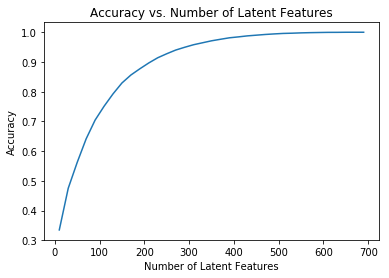

In [41]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [47]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts



In [43]:
print("Total test set users available for prediction:")
train_test_intersect_u = np.intersect1d(df_train.user_id.unique(), df_test.user_id.unique())
print(len(train_test_intersect_u))

print("Total test set users unavailable for prediction:")
print(df_test.user_id.nunique() - len(train_test_intersect_u))

print("Total test set articles available for prediction:")
train_test_intersect_a = np.intersect1d(df_train.article_id.unique(), df_test.article_id.unique())
print(len(train_test_intersect_a))

print("Total test set articles not available for prediction:")
print(df_test.article_id.nunique() - len(train_test_intersect_a))

Total test set users available for prediction:
20
Total test set users unavailable for prediction:
662
Total test set articles available for prediction:
574
Total test set articles not available for prediction:
0


In [44]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many articles can we make predictions for in the test set?': b,# letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [48]:
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [45]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [58]:
# select intersect of users
test_users_idx = user_item_train.index.isin(test_idx)

# select intersect of articles
test_items_idx = user_item_train.columns.isin(test_arts)

# reshape U, Vt test matrices
u_test = u_train[test_users_idx, :]
vt_test = vt_train[:, test_items_idx]

# get subset of user_item_test 
user_test_sub = user_item_test.loc[user_item_test.index.isin(user_item_train.index)]

print(u_test.shape)
print(vt_test.shape)
print(user_test_sub.shape)

(20, 4487)
(714, 574)
(20, 574)


100%|██████████████████████████████████████████| 88/88 [00:23<00:00,  2.83it/s]


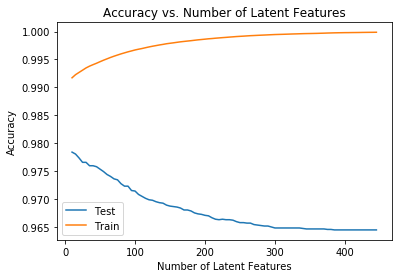

In [68]:
from tqdm import tqdm
lat_feats = np.arange(10, 450, 5)

train_errs = []
test_errs = []

for k in tqdm(lat_feats):
    
    # restructure with k latent features
    sigma = np.diag(s_train[:k])
    
    u_train_k, vt_train_k = u_train[:, :k], vt_train[:k, :]
    
    u_test_k, vt_test_k = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    train_pred = np.around(np.dot(np.dot(u_train_k, sigma), vt_train_k))
    test_pred = np.around(np.dot(np.dot(u_test_k, sigma), vt_test_k))
    
    # compute error for each prediction to actual value
    train_diffs = np.subtract(user_item_train, train_pred)
    test_diffs = np.subtract(user_test_sub, test_pred)
    
    # total errors and keep track of them
    train_errs.append(np.sum(np.sum(np.abs(train_diffs))))
    test_errs.append(np.sum(np.sum(np.abs(test_diffs))))
    
    
n_train_interactions = user_item_train.shape[0]*user_item_train.shape[1]
n_test_interactions = user_test_sub.shape[0]*user_test_sub.shape[1]
    
plt.figure()
plt.plot(lat_feats,1 - np.array(test_errs)/n_test_interactions, label='Test')
plt.plot(lat_feats, 1-np.array(train_errs)/n_train_interactions, label='Train')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

There is an obvious class-imbalance issue within the dataset, with non-interactions being the dominant class. Training accuracy increases as we increase the number of latent features to use for prediction while Testing accuracy decreases. 

Selecting multiple subsets of the data could be one optimization strategy to determine the appropriate amount of latent features. Regularaization penalties, or early stopping could also be used to help prevent overfitting of SVD. 

As mentioned prior, none of my recommender systems here adequately address the 'cold-start' problem - but SVD can be a good starting point towards tackling that. As Kojin Oshiba points out in this article (https://kojinoshiba.com/recsys-cold-start/), Representative Based Matrix Factorization can be used as an extension of existing Matrix Factorization methods. In this extension of SVD, a new user can be asked to simply rate a series of items and from these preferences - linear combinations are used to approximate suggestions from similar users. As Kojin notes, this would require changes to UI and front end logic however one can find this method permeated in a variety of websites (eg. Medium.com comes to mind).  

Next steps I would take personally outside of the constraints of this project space would be to utilize my CosineRecSys class and integrate matrix factorization with the goal of identifying latent features within the vectorized texts. 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0